# 0.0 IMPORTS

## 0.1 Libraries

In [37]:
import inflection
import warnings
import pandas as pd
import numpy as np
import scipy.stats  as ss

from IPython.display         import Image
from IPython.core.display    import HTML

# stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

### 0.1.1 Notebook Config

In [38]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    seed = 42
    np.random.seed(seed)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [39]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Helper Functions

In [69]:
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Mni', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m

## 0.3 Load Data

In [4]:
df_raw = pd.read_csv('../../01-Data/churn.csv')

In [5]:
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 0.3.1 Split data into train and test dataset

In [12]:
# Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for train_index, test_index in split.split(df_raw, df_raw['Exited']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)

### 0.3.2 Saving Train and Test Dataset

In [13]:
# Convert to .Feather Data
train_dataset.to_feather('00-Data/train_dataset.feather')
test_dataset.to_feather('00-Data/test_dataset.feather')

### 0.3.3 Load Train Dataset

In [15]:
df_train_dataset = pd.read_feather('00-Data/train_dataset.feather')

# 1.0 DATA DESCRIPTION

In [16]:
df01 = df_train_dataset.copy()

## 1.1 Data Information
---

> - **RowNumber:**       Corresponds to the record (row) number;
> - **CustomerId:**      Contains unique identifier;
> - **Surname:**         Customer's surname;
> - **CreditScore:**     Customer's credit score for the consumer market;
> - **Geography:**       Customer’s country;
> - **Gender:**          Customer's gender;
> - **Age:**             Customer's age;
> - **Tenure:**          Number of years that the customer has been a client of the bank;
> - **Balance:**         The amount that the customer has in the bank account;
> - **NumOfProducts:**   Refers to the number of products that a customer has purchased through the bank;
> - **HasCrCard:**       Denotes whether or not a customer has a credit card;
> - **IsActiveMember:**  Denotes whether or not a customer is an active member;
> - **EstimatedSalary:** Estimate customer's annually income;
> - **Exited:**          Whether or not the customer is in Churn;

## 1.2 Columns

In [17]:
df01.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### 1.2.1 Rename Columns

In [20]:
snakecase = lambda col: inflection.underscore(col)

new_columns = list(map(snakecase, df01.columns))

# rename
df01.columns = new_columns

#### 1.2.2 New Name Columns

In [21]:
df01.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Data Dimensions

In [22]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 8000
Number of Columns: 14


## 1.4 Data Types

In [23]:
df01.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.5 Not a Number

### 1.5.1 Sum NA

In [24]:
df01.isnull().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

### 1.5.2 ~~Fillout NA~~

there is no NA values

## 1.6 Descriptive Statistical

In [25]:
# Numerical Attributes
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
not_numerial = ['row_number', 'customer_id']
num_attributes_cols = list(np.setdiff1d(num_attributes.columns, not_numerial))
num_attributes = num_attributes[num_attributes_cols]

#Categorical Attributes
cat_attributes = df01.select_dtypes(include=['object'])

### 1.5.1 Numerical Attributes

In [70]:
## Statatistical Summary (Helper Function)
statistical_summary(num_attributes)

,Attributes,Mni,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,age,18.00,92.00,74.00,35.00,38.946625,37.000,25.0000,27.000,32.0000,44.000,53.000,60.000,10.526219,0.270273,1.035706,1.459448
1,balance,0.00,238387.56,238387.56,0.00,76381.207499,97055.145,0.0000,0.000,0.0000,127633.195,149005.811,162442.667,62298.159597,0.815622,-0.141721,-1.492209
2,credit_score,350.00,850.00,500.00,850.00,650.752500,652.000,489.0000,522.000,584.0000,717.000,778.000,812.000,96.590394,0.148429,-0.079540,-0.418624
3,estimated_salary,11.58,199992.48,199980.90,24924.92,99730.811581,99446.940,9903.3685,20330.208,50691.8175,148527.730,179035.035,190113.789,57331.532983,0.574863,0.007126,-1.174789
4,exited,0.00,1.00,1.00,0.00,0.203750,0.000,0.0000,0.000,0.0000,0.000,1.000,1.000,0.402785,1.976860,1.471283,0.164715
5,has_cr_card,0.00,1.00,1.00,1.00,0.708750,1.000,0.0000,0.000,0.0000,1.000,1.000,1.000,0.454338,0.641042,-0.919091,-1.155561
6,is_active_member,0.00,1.00,1.00,1.00,0.514875,1.000,0.0000,0.000,0.0000,1.000,1.000,1.000,0.499779,0.970680,-0.059538,-1.996955
7,num_of_products,1.00,4.00,3.00,1.00,1.529500,1.000,1.0000,1.000,1.0000,2.000,2.000,2.000,0.581704,0.380323,0.755984,0.636943
8,tenure,0.00,10.00,10.00,2.00,5.016625,5.000,1.0000,1.000,3.0000,8.000,9.000,9.000,2.896610,0.577402,0.013124,-1.172842


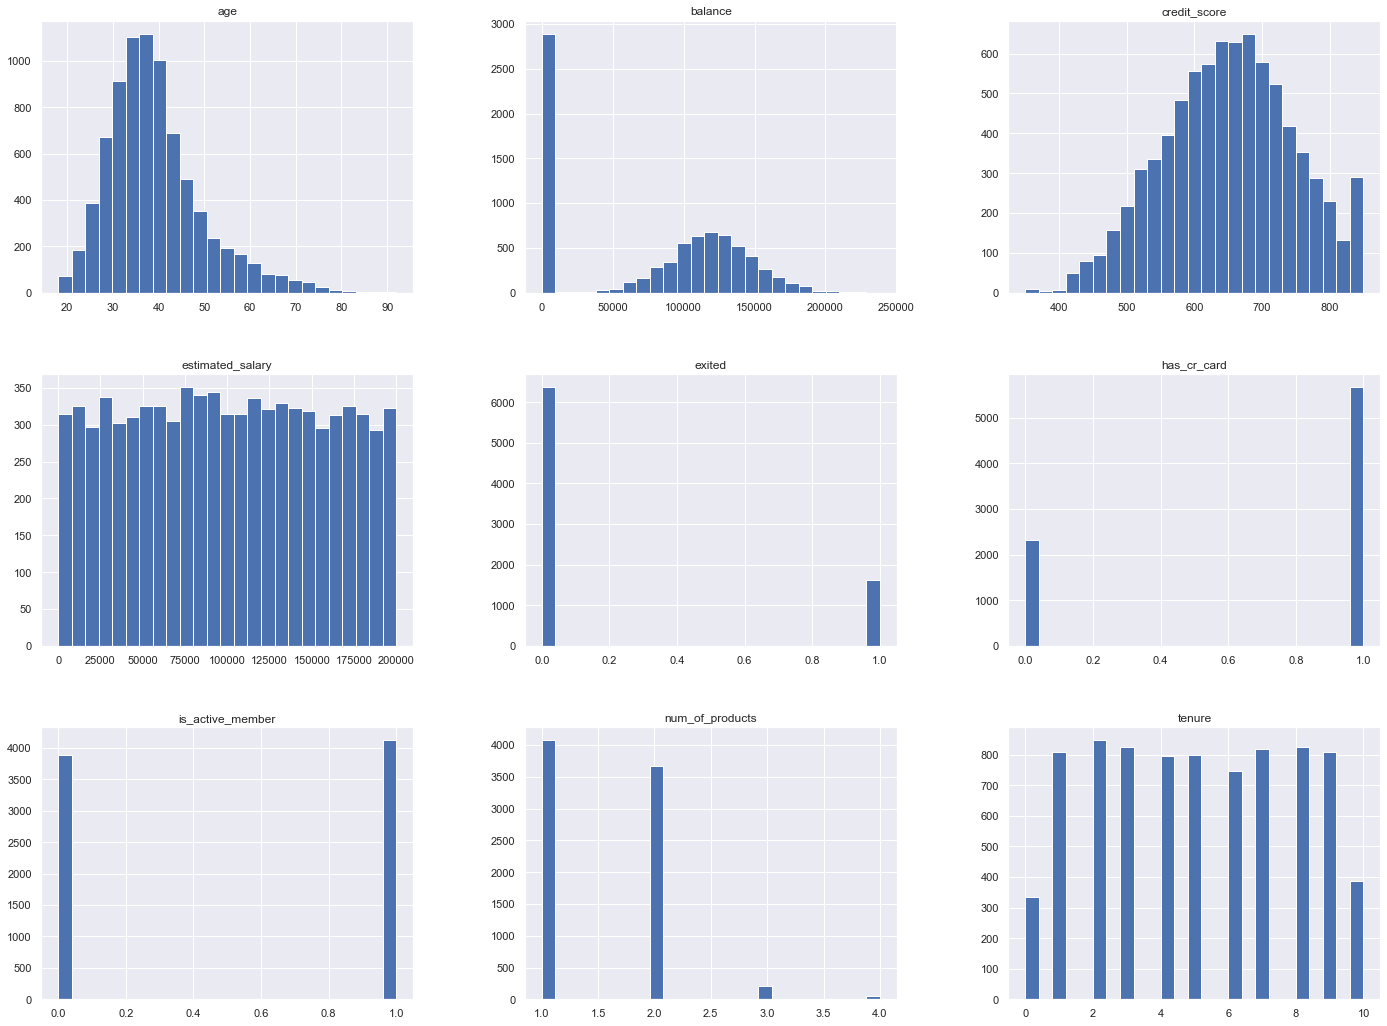

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
num_attributes.hist(bins=25, figsize=(24,18));

#### 1.5.1.2 Some considerations
---
> **age**
>> - The age range is large and it will be interesting to group by bands
>> - 50% are between 32 and 44 years (Adults)
>
> **balance**
>> - According to the relative std the distribution presents a great degree of dispersion
>> - Almost 38% equals 0.00
>
> **credit_score**
>> - Although it has a high std, it has a relative low std which shows a small degree of dispersion
>> - Both Skew and low kurtosis show that the distribution is close to a normal curve
>> - However close the average and median are, the mode is consiversibly greater and evidences the asymmetry of the distribution
>
> **estimated_salary**
>> - As the distribution has a very high std and a relative std as well, it can be noted that it is a uniform distribution with great dispersion
>
> **has_cr_card**
>> - 75% has credit card
>
> **is_active_member**
>> - 50% of the customers has done a bank activity in the past 12 months
>
> **num_of_products**
>> - all customers have bought at least one product
>
> **tenure**
>> - According to the relative std the distribution presents a great degree of dispersion
>

>
> **exited**
>> - Customers in Churn: 20% (Disbalanced Dataset) 

In [94]:
tenure_percentage = num_attributes['tenure'].value_counts(normalize=True).sort_index()

tenure_percentage_hue_churn['churn'] = num_attributes['tenure'][num_attributes['exited'] == 1].value_counts(normalize=True).sort_index()
tenure_percentage_hue_churn['not_churn'] = num_attributes['tenure'][num_attributes['exited'] != 1].value_counts(normalize=True).sort_index()

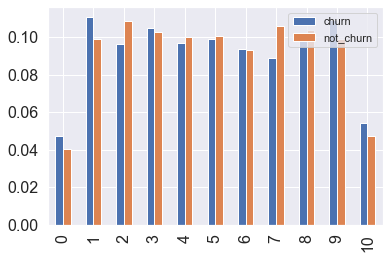

In [97]:
tenure_percentage_hue_churn.plot(kind='bar', stacked=False, fontsize=16);

In [ ]:
#https://gitlab.com/datascience-community/pa003_churn_predict/-/blob/pa003_bruno_santos/pa003_churn_prediction_V01.ipynb